In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

import os
from distutils.dir_util import copy_tree, remove_tree

from PIL import Image
from random import randint

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef as MCC
from sklearn.metrics import balanced_accuracy_score as BAS
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow_addons as tfa
from keras.utils import plot_model
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator as IDG
from tensorflow.keras.layers import SeparableConv2D, BatchNormalization, GlobalAveragePooling2D

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tensorflow_addons as tfa

print("TensorFlow Version:", tf.__version__)
# 2.15.0

In [5]:
import os
from distutils.dir_util import copy_tree
from shutil import rmtree

base_dir = "C:/Users/User/Alzheimer_s Dataset/Alzheimer_s Dataset/"
root_dir = "./"
test_dir = os.path.join(base_dir, "test/")
train_dir = os.path.join(base_dir, "train/")
work_dir = os.path.join(root_dir, "dataset/")

if os.path.exists(work_dir):
    rmtree(work_dir)

os.makedirs(work_dir)
copy_tree(train_dir, work_dir)
copy_tree(test_dir, work_dir)
print("Working Directory Contents:", os.listdir(work_dir))


Working Directory Contents: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [6]:
WORK_DIR = './dataset/'

CLASSES = [ 'NonDemented',
            'VeryMildDemented',
            'MildDemented',
            'ModerateDemented']

IMG_SIZE = 176
IMAGE_SIZE = [176, 176]
DIM = (IMG_SIZE, IMG_SIZE)

In [7]:
#Performing Image Augmentation to have more data samples

ZOOM = [.99, 1.01]
BRIGHT_RANGE = [0.8, 1.2]
HORZ_FLIP = True
FILL_MODE = "constant"
DATA_FORMAT = "channels_last"

work_dr = IDG(rescale = 1./255, brightness_range=BRIGHT_RANGE, zoom_range=ZOOM, data_format=DATA_FORMAT, fill_mode=FILL_MODE, horizontal_flip=HORZ_FLIP)

train_data_gen = work_dr.flow_from_directory(directory=WORK_DIR, target_size=DIM, batch_size=6500, shuffle=False)

Found 6400 images belonging to 4 classes.


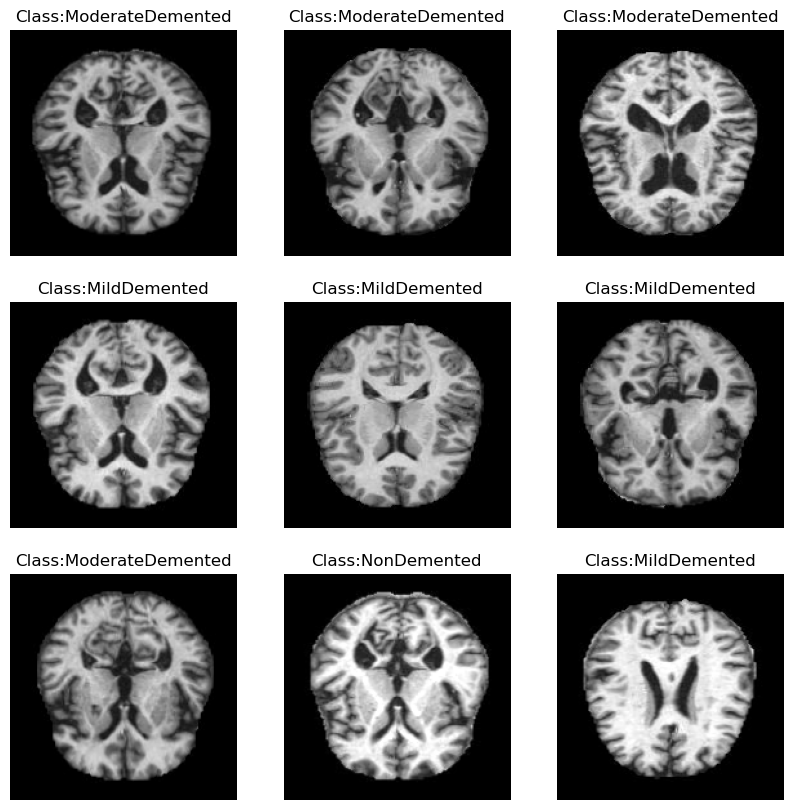

In [8]:
def show_images(generator,y_pred=None):
    """
    Input: An image generator,predicted labels (optional)
    Output: Displays a grid of 9 images with lables
    """
    
    # get image lables
    labels =dict(zip([0,1,2,3], CLASSES))
    
    # get a batch of images
    x,y = generator.next()
    
    # display a grid of 9 images
    plt.figure(figsize=(10, 10))
    if y_pred is None:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            idx = randint(0, 6400)
            plt.imshow(x[idx])
            plt.axis("off")
            plt.title("Class:{}".format(labels[np.argmax(y[idx])]))
                                                     
    else:
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(x[i])
            plt.axis("off")
            plt.title("Actual:{} \nPredicted:{}".format(labels[np.argmax(y[i])],labels[y_pred[i]]))
    
# Display Train Images
show_images(train_data_gen)

In [9]:
#Retrieving the data from the ImageDataGenerator iterator

train_data, train_labels = train_data_gen.next()

In [10]:
#Getting to know the dimensions of our dataset

print(train_data.shape, train_labels.shape)

(6400, 176, 176, 3) (6400, 4)


In [11]:
#Performing over-sampling of the data, since the classes are imbalanced

sm = SMOTE(random_state=42)

train_data, train_labels = sm.fit_resample(train_data.reshape(-1, IMG_SIZE * IMG_SIZE * 3), train_labels)

train_data = train_data.reshape(-1, IMG_SIZE, IMG_SIZE, 3)

print(train_data.shape, train_labels.shape)

(12800, 176, 176, 3) (12800, 4)


In [12]:
#Splitting the data into train, test, and validation sets

train_data, test_data, train_labels, test_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size = 0.2, random_state=42)

### Using the VGG16 model as a base model for the task

In [13]:
# Load VGG16 as base model
vgg_model = VGG16(input_shape=(176, 176, 3), include_top=False, weights="imagenet")

In [14]:
for layer in vgg_model.layers:
    layer.trainable = False

In [15]:
# Constructing your custom model
custom_vgg_model = Sequential([
    vgg_model,
    Flatten(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dense(4, activation='softmax')
], name="vgg16_cnn_model")

In [16]:
# Define custom callback to stop training when accuracy goes above 99%
class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('acc') > 0.99:
            print("\nReached accuracy threshold! Terminating training.")
            self.model.stop_training = True

my_callback = MyCallback()

# ReduceLROnPlateau to stabilize the training process of the model
rop_callback = ReduceLROnPlateau(monitor="val_loss", patience=3)

In [19]:
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc'),
           tfa.metrics.F1Score(num_classes=4)]

CALLBACKS = [my_callback, rop_callback]

custom_vgg_model.compile(optimizer='rmsprop',
                         loss=tf.losses.CategoricalCrossentropy(),
                         metrics=METRICS)

custom_vgg_model.summary()

Model: "vgg16_cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 12800)             0         
                                                                 
 dropout (Dropout)           (None, 12800)             0         
                                                                 
 dense (Dense)               (None, 512)               6554112   
                                                                 
 batch_normalization (Batch  (None, 512)               2048      
 Normalization)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                   

In [20]:
EPOCHS = 10

history = custom_vgg_model.fit(train_data, train_labels, validation_data=(val_data, val_labels), callbacks=CALLBACKS, epochs=EPOCHS)

Epoch 1/10
256/256 [==============================] - 350s 1s/step - loss: 0.9957 - acc: 0.5450 - auc: 0.8204 - f1_score: 0.5346 - val_loss: 0.7826 - val_acc: 0.6499 - val_auc: 0.8967 - val_f1_score: 0.6164 - lr: 0.0010
Epoch 2/10
256/256 [==============================] - 344s 1s/step - loss: 0.8033 - acc: 0.6334 - auc: 0.8815 - f1_score: 0.6285 - val_loss: 0.5922 - val_acc: 0.7188 - val_auc: 0.9329 - val_f1_score: 0.7147 - lr: 0.0010
Epoch 3/10
256/256 [==============================] - 344s 1s/step - loss: 0.7411 - acc: 0.6633 - auc: 0.8992 - f1_score: 0.6593 - val_loss: 0.5394 - val_acc: 0.7578 - val_auc: 0.9466 - val_f1_score: 0.7579 - lr: 0.0010
Epoch 4/10
256/256 [==============================] - 340s 1s/step - loss: 0.7087 - acc: 0.6859 - auc: 0.9089 - f1_score: 0.6847 - val_loss: 0.5508 - val_acc: 0.7427 - val_auc: 0.9430 - val_f1_score: 0.7414 - lr: 0.0010
Epoch 5/10
256/256 [==============================] - 337s 1s/step - loss: 0.6668 - acc: 0.7053 - auc: 0.9192 - f1_score

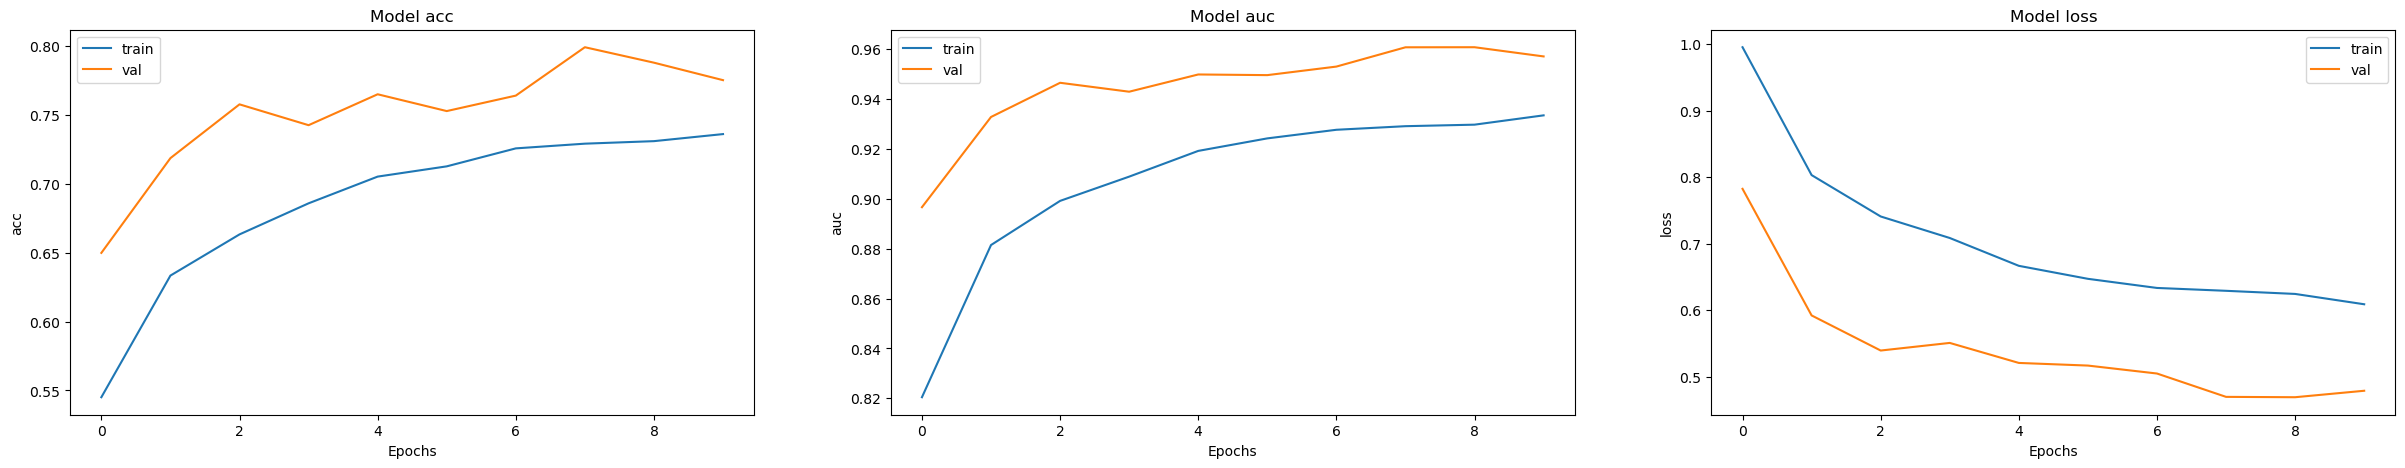

In [21]:
# Plotting the trend of the metrics during training
fig, ax = plt.subplots(1, 3, figsize=(30, 5))
ax = ax.ravel()

for i, metric in enumerate(["acc", "auc", "loss"]):
    ax[i].plot(history.history[metric])
    ax[i].plot(history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [22]:
# Evaluating the model on the test data
test_scores = custom_vgg_model.evaluate(test_data, test_labels)
print("Testing Accuracy: %.2f%%" % (test_scores[1] * 100))

train_scores = custom_vgg_model.evaluate(train_data, train_labels)
val_scores = custom_vgg_model.evaluate(val_data, val_labels)

print("Training Accuracy: %.2f%%"%(train_scores[1] * 100))
print("Validation Accuracy: %.2f%%"%(val_scores[1] * 100))

80/80 [==============================] - 83s 1s/step - loss: 0.5137 - acc: 0.7648 - auc: 0.9507 - f1_score: 0.7577
Testing Accuracy: 76.48%
64/64 [==============================] - 66s 1s/step - loss: 0.4789 - acc: 0.7754 - auc: 0.9572 - f1_score: 0.7656
Training Accuracy: 80.51%
Validation Accuracy: 77.54%


In [23]:
# Predicting the test data
pred_labels = custom_vgg_model.predict(test_data)

80/80 [==============================] - 86s 1s/step


In [24]:
# Print the classification report of the tested data
def roundoff(arr):
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in pred_labels:
    labels = roundoff(labels)

print(classification_report(test_labels, pred_labels, target_names=CLASSES))

                  precision    recall  f1-score   support

     NonDemented       0.66      0.92      0.76       639
VeryMildDemented       1.00      1.00      1.00       635
    MildDemented       0.79      0.64      0.71       662
ModerateDemented       0.64      0.50      0.56       624

       micro avg       0.76      0.76      0.76      2560
       macro avg       0.77      0.76      0.76      2560
    weighted avg       0.77      0.76      0.76      2560
     samples avg       0.76      0.76      0.76      2560



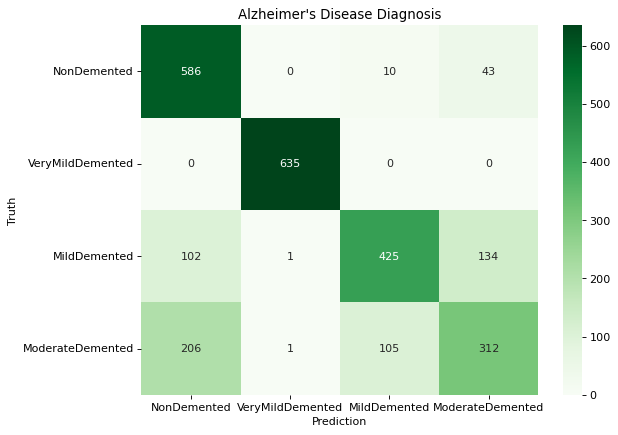

In [25]:
# Plot the confusion matrix
pred_ls = np.argmax(pred_labels, axis=1)
test_ls = np.argmax(test_labels, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)
plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Greens', annot=True, fmt='d', xticklabels = CLASSES, yticklabels=CLASSES)
plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [26]:
# Printing some other classification metrics
print("Balanced Accuracy Score: {} %".format(round(BAS(test_ls, pred_ls) * 100, 2)))
print("Matthew's Correlation Coefficient: {} %".format(round(MCC(test_ls, pred_ls) * 100, 2)))

Balanced Accuracy Score: 76.48 %
Matthew's Correlation Coefficient: 69.34 %


### Save

In [34]:
# Saving the model for future use === h5
custom_mobilenet_model_dir = work_dir + "alzheimer_mobilenet_cnn_model_mobilenetv3"
custom_mobilenet_model.save(custom_mobilenet_model_dir, save_format='h5')
os.listdir(work_dir)

C:\Users\User\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


['alzheimer_mobilenet_cnn_model_mobilenetv3',
 'alzheimer_mobilenet_cnn_model_mobilenetv3.tflite',
 'MildDemented',
 'model_plot_new.png',
 'ModerateDemented',
 'NonDemented',
 'VeryMildDemented']

In [35]:
import tensorflow as tf

# Load the saved model from the .h5 file
custom_mobilenet_model = tf.keras.models.load_model(custom_mobilenet_model_dir)

# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(custom_mobilenet_model)
tflite_model = converter.convert()

# Save the TFLite model to a file
tflite_model_dir = work_dir + "alzheimer_mobilenet_cnn_model_mobilenetv3.tflite"
with open(tflite_model_dir, 'wb') as f:
    f.write(tflite_model)

# List the files in the working directory to verify the saved TFLite model
print(os.listdir(work_dir))


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpo15aiwml\assets


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpo15aiwml\assets


['alzheimer_mobilenet_cnn_model_mobilenetv3', 'alzheimer_mobilenet_cnn_model_mobilenetv3.tflite', 'MildDemented', 'model_plot_new.png', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


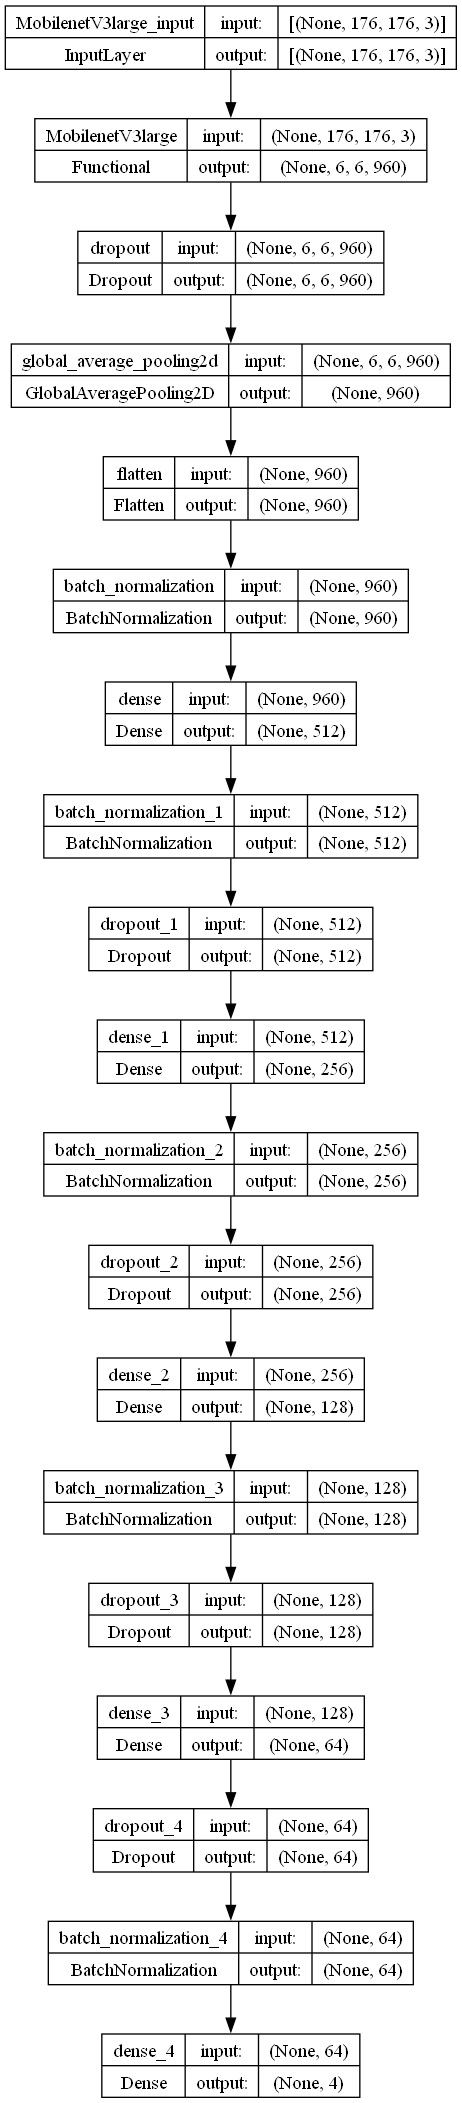

In [36]:


# Load the saved model
pretrained_model = tf.keras.models.load_model(custom_mobilenet_model_dir)

# Check its architecture
tf.keras.utils.plot_model(pretrained_model, to_file=work_dir + "model_plot_new.png", show_shapes=True, show_layer_names=True)

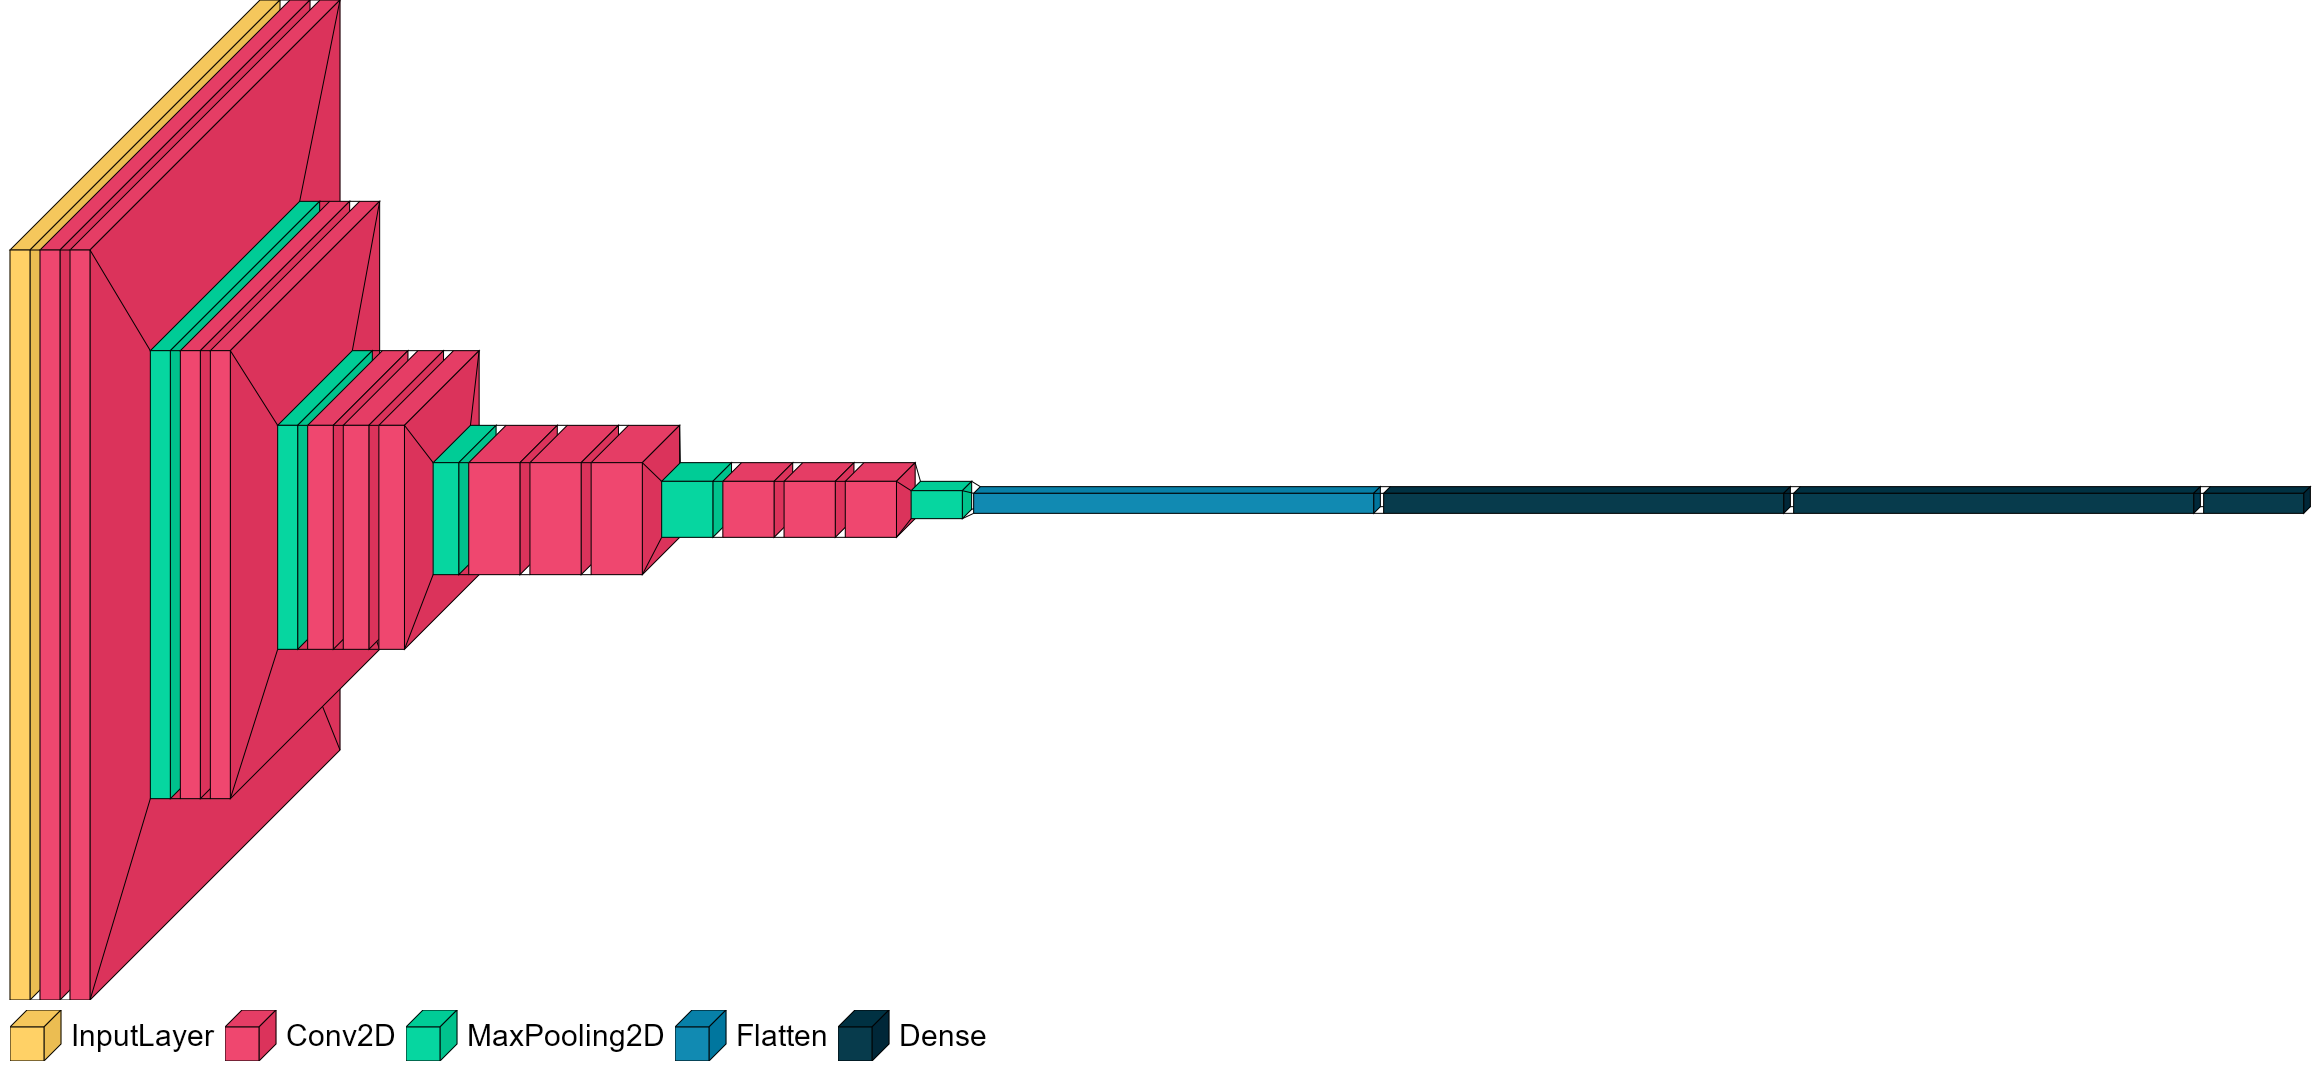

In [37]:
from PIL import ImageFont
import tensorflow as tf
from visualkeras import layered_view

# Load a pretrained model, for example, VGG16
pretrained_model = tf.keras.applications.VGG16()

# Create a custom font object with a larger size
custom_font = ImageFont.truetype("arial.ttf", 30)  # Adjust the size (20) as needed

# Create the visualization with the custom font
layered_view(pretrained_model, legend=True, max_xy=750, font=custom_font)
